Import public packages and functions

In [54]:
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import math
import statistics as stat
import json
from scipy import interp
from scipy import stats
import pingouin as pg
from itertools import product as prod
from sklearn.preprocessing import MinMaxScaler
from scikit_posthocs import posthoc_dunn

Import Cross Validation Packages

In [26]:
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder

Import Classifiers

In [27]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc

In [28]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)

    return path

In [29]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')
os.chdir(code_path)

Import own functions

In [30]:
import sig_processing.extract_scores as sc_ext
import sig_processing.predict as pred
import plotting.boxplotting as bxplt
import statistic.stat_analysis as statis

### 1. Loading features (X) and scores (y)

Load features from csv

In [31]:
# define task & folder
task = 'ft'
folder  = 'patientdata'
# feat_file = 'new_features'
feat_file = 'new_features'

feat_df_path = os.path.join(
    repo_path,
    'EDA',
    folder,
    task, 
    f'{feat_file}.csv'
    )

X_df = pd.read_csv(feat_df_path, index_col=0)

In [32]:
importlib.reload(bxplt)

<module 'plotting.boxplotting' from 'c:\\Users\\madal\\Projects\\Thesis\\ultraleap_analysis\\code\\plotting\\boxplotting.py'>

Load scores/labels

In [33]:
y_with_nan = sc_ext.get_labels_for_feat_df(X_df)

No scores for block ('b1', 'ul020', 'm1s1', 'dt', 'ft', 'lh') or this combination does not exist
No scores for block ('b2', 'ul020', 'm1s1', 'dt', 'ft', 'lh') or this combination does not exist
No scores for block ('b3', 'ul020', 'm1s1', 'dt', 'ft', 'lh') or this combination does not exist


In [43]:
y = np.array([i for i in y_with_nan if not np.isnan(i)])

Remove non-scored/non-existing rows/blocks

In [35]:
try:
    X_df = sc_ext.remove_non_score_rows(X_df, y_with_nan)
except KeyError:
    print('Non-scored/non-existing rows/blocks have already been scored.')

### 2. Feature Box Plots
Box Plots per condition, score and grouped scores

In [40]:
importlib.reload(bxplt)
feats = X_df.columns[1:]
X_df['condition'] = X_df['file'].apply(lambda x: x.split('_')[2] if len(x.split('_')) > 2 else None)
for bx_label in ['condition', 'scores', 'grouped_scores']:
    for feat in feats:
        bxplt.boxplot(feat, bx_label, X_df, y, task)

In [21]:
columns_to_drop = ['score', 'file', 'condition']

for column in columns_to_drop:
    if column in X_df.columns:
        X_df = X_df.drop(columns=[column])


### 3. Kolmogorov-Smirnov Test 

Feature Normalization

In [25]:
# X_norm = MinMaxScaler().fit_transform(X_df.iloc[:,1:]) # y = (x – min) / (max – min)

# New DataFrame with normalized features
# X_df_norm = pd.DataFrame(data=X_norm, columns=X_df.iloc[:,1:].columns)

In [28]:
importlib.reload(statis)
test = 'Kolmogorov_Smirnov'
test_normality = statis.kolm_smir_test(X_df, task, test, feat_file, to_save=True)
# test_normality = statis.kolm_smir_test(X_df_norm)

DataFrame is written to Excel File successfully.


,Feature,Statistic,P-Value
17,slope_tap_dur,0.327156,2.817989e-17
5,decr_max_dist,0.312031,1.008652e-15
15,sd_tap_dur,0.219495,6.311456e-08
4,slope_max_dist,0.209216,3.092465e-07
23,entropy,0.179183,2.047111e-05
20,slope_rms,0.164510,1.246836e-04
19,sd_rms,0.155668,3.433313e-04
2,sd_max_dist,0.154126,4.072961e-04
7,sd_max_vel,0.150810,5.846334e-04
3,coef_var_max_dist,0.149524,6.711946e-04


### 4. Significance Tests - Kruskal-Wallis

Given that the data doesn't meet the assumptions of normality and equal variances (homoscedasticity), and I have a multiclass target, I could consider using non-parametric tests that do not require these assumptions. For the multiclass target scenario, the Kruskal-Wallis H test could be an appropriate choice.

The Kruskal-Wallis H test is a nonparametric (distribution-free) test, and it is used to compare three or more groups of data. It extends the Mann-Whitney U test, which is used for comparing only two groups. It's essentially an ANOVA with the data ranks.

In [19]:
len(X_df.iloc[:,1:-1].columns)

24

Levene Test

In [ ]:
from scipy import stats

# Assuming df is your DataFrame, target is your target column name, and feature is one of your features
groups = [df[df[target]==val][feature].values for val in df[target].unique()]

# Levene's test
W, p_val = stats.levene(*groups)

print(f"Levene's test for homoscedasticity:\nW = {W}\np-value = {p_val}")

# Bartlett's test
T, p_val = stats.bartlett(*groups)

print(f"\nBartlett's test for homoscedasticity:\nT = {T}\np-value = {p_val}")


Kruskal-Wallis Test

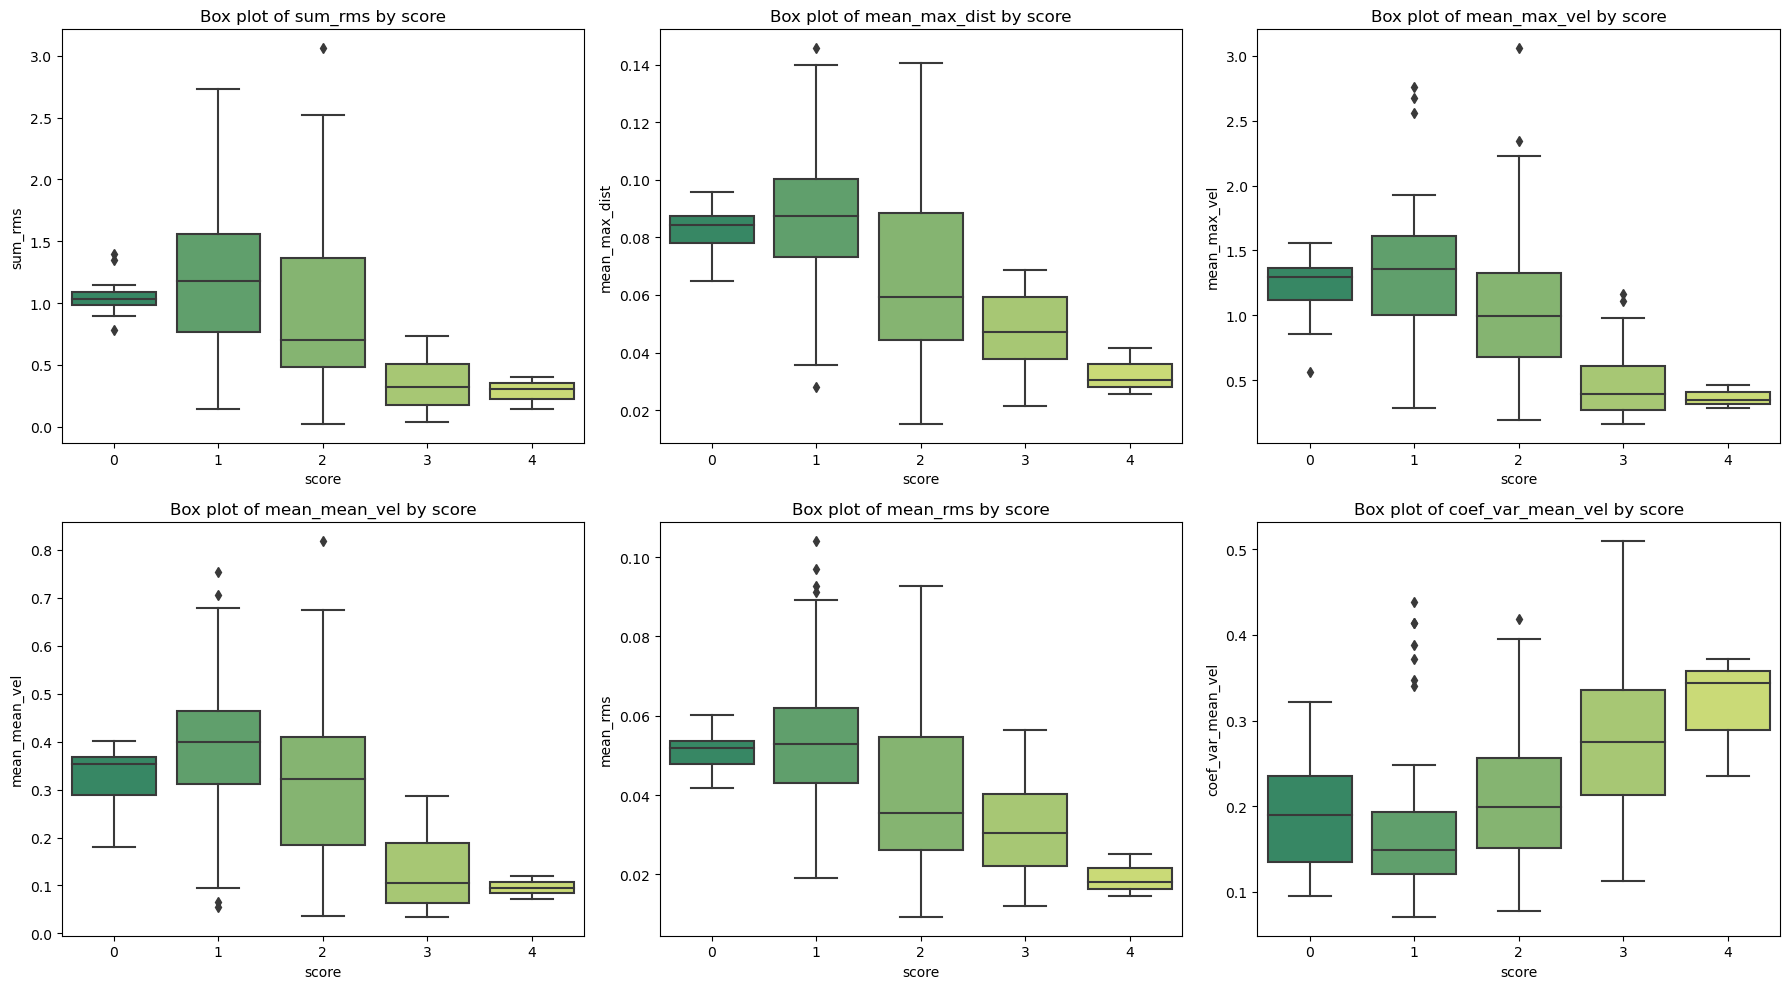

DataFrame is written to Excel File successfully.


,feature,H_statistic,p_value
21,sum_rms,58.545264,5.862834e-12
1,mean_max_dist,57.381392,1.028986e-11
6,mean_max_vel,56.925389,1.282571e-11
10,mean_mean_vel,55.558144,2.481871e-11
18,mean_rms,47.284034,1.330696e-09
12,coef_var_mean_vel,36.813467,1.967930e-07
7,sd_max_vel,35.821548,3.148900e-07
0,num_events,32.305471,1.656874e-06
3,coef_var_max_dist,29.431001,6.389509e-06
14,mean_tap_dur,23.933720,8.235569e-05


['sum_rms',
 'mean_max_dist',
 'mean_max_vel',
 'mean_mean_vel',
 'mean_rms',
 'coef_var_mean_vel',
 'sd_max_vel',
 'num_events',
 'coef_var_max_dist',
 'mean_tap_dur',
 'sd_mean_vel',
 'sd_tap_dur']

In [40]:
importlib.reload(statis)
test = 'Kruskal_Wallis'
test_kruskal = statis.krusk_wal_test(X_df, y, task, test, feat_file, to_save=True)

In [51]:
significant_features = test_kruskal[test_kruskal['p_value']<=0.002].feature.to_list()
X_df_signif_feats = X_df[significant_features]
X_df_signif_feats.insert(X_df_signif_feats.shape[1],'score',y)
X_df_signif_feats

,sum_rms,mean_max_dist,mean_max_vel,mean_mean_vel,mean_rms,coef_var_mean_vel,sd_max_vel,num_events,coef_var_max_dist,mean_tap_dur,sd_mean_vel,sd_tap_dur,score
0,2.200725,0.139824,2.756138,0.753178,0.088029,0.102546,0.472769,26.0,0.043961,0.418023,0.077235,0.146259,1
1,2.734930,0.134933,2.559501,0.679702,0.091164,0.094988,0.425132,31.0,0.030256,0.360868,0.064563,0.031789,1
2,1.040681,0.086324,1.531217,0.473704,0.054773,0.239461,0.322006,20.0,0.222004,0.487451,0.113433,0.093077,1
3,1.369295,0.086305,1.894720,0.472234,0.054772,0.230737,0.857292,26.0,0.196150,0.437970,0.108962,0.093196,2
4,1.488425,0.100558,2.345756,0.549521,0.064714,0.174882,0.899337,24.0,0.101979,0.427845,0.096101,0.082475,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.235633,0.044480,0.397632,0.139674,0.029454,0.355907,0.133423,9.0,0.203708,0.445870,0.049711,0.098635,3
196,0.035979,0.023934,0.347057,0.057883,0.011993,0.353676,0.071135,4.0,0.139512,1.014140,0.020472,0.327512,3
197,0.307124,0.025543,0.345630,0.094482,0.014625,0.235238,0.097573,22.0,0.237108,0.467687,0.022226,0.123651,4
198,0.029165,0.020624,0.318934,0.053036,0.009722,0.182425,0.032386,4.0,0.016828,2.088555,0.009675,2.056497,2


KeyError: 'p-value'

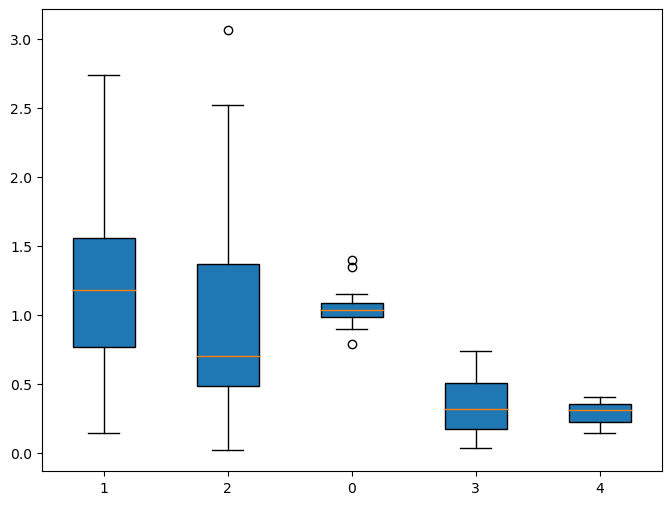

In [64]:
# # Find significant features
# significant_features = []
# for feature in X_df_signif_feats.columns[:-1]:
#     dunn_results = posthoc_dunn(X_df_signif_feats, val_col=feature, group_col='score')
#     min_p_value = dunn_results.values[dunn_results.values > 0].min()
#     if min_p_value < 0.05:  # Adjust significance threshold as needed
#         significant_features.append(feature)


# Create box plots with significance annotations for significant features
# for feature in significant_features:
#     plt.figure(figsize=(8, 6))
#     box = plt.boxplot(
#         [X_df_signif_feats[X_df_signif_feats['score'] == group][feature] for group in X_df_signif_feats['score'].unique()],
#         labels=X_df_signif_feats['score'].unique(),
#         patch_artist=True
#     )
    
#     # Add significance annotations
#     dunn_results = posthoc_dunn(X_df_signif_feats, val_col=feature, group_col='score')
    
#     # Convert the index to a list of tuples
#     box_pairs = list(dunn_results.index)
    
#     for i, (box1, box2) in enumerate(box_pairs):
#         p_value = dunn_results.loc[(box1, box2)]
#         if p_value < 0.05:
#             y_pos = max(box['medians'][i].get_ydata()) + 0.1
#             plt.text(i + 1, y_pos, '*', ha='center', va='center', color='red', fontweight='bold')
    
#     plt.title(f'Box Plot for {feature} with Significance Annotations')
#     plt.ylabel(feature)
#     plt.xlabel('Score')
#     plt.grid(True, axis='y', linestyle='--', alpha=0.7)
#     plt.show()


# Create box plots with significance annotations for significant features
for feature in significant_features:
    plt.figure(figsize=(8, 6))
    box = plt.boxplot(
        [X_df_signif_feats[X_df_signif_feats['score'] == group][feature] for group in X_df_signif_feats['score'].unique()],
        labels=X_df_signif_feats['score'].unique(),
        patch_artist=True
    )
    
    # Add significance annotations
    dunn_results = posthoc_dunn(X_df_signif_feats, val_col=feature, group_col='score')
    
    for i, row in dunn_results.iterrows():
        p_value = row['p-value']
        if p_value < 0.05:
            box1, box2 = i  # Unpack the row index (box pair)
            y_pos = max(box['medians'][i].get_ydata()) + 0.1
            plt.text(i + 1, y_pos, '*', ha='center', va='center', color='red', fontweight='bold')
    
    plt.title(f'Box Plot for {feature} with Significance Annotations')
    plt.ylabel(feature)
    plt.xlabel('Score')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()



# # Create box plots with significance annotations for significant features
# for feature in significant_features:
#     plt.figure(figsize=(8, 6))
#     box = plt.boxplot(
#         [X_df_signif_feats[X_df_signif_feats['score'] == group][feature] for group in X_df_signif_feats['score'].unique()],
#         labels=X_df_signif_feats['score'].unique(),
#         patch_artist=True
#     )
    
#     # Add significance annotations
#     dunn_results = posthoc_dunn(X_df_signif_feats, val_col=feature, group_col='score')
#     for i, (box1, box2) in enumerate(dunn_results.index):
#         p_value = dunn_results.loc[(box1, box2)]
#         if p_value < 0.05:
#             y_pos = max(box['medians'][i].get_ydata()) + 0.1
#             plt.text(i + 1, y_pos, '*', ha='center', va='center', color='red', fontweight='bold')
    
#     plt.title(f'Box Plot for {feature} with Significance Annotations')
#     plt.ylabel(feature)
#     plt.xlabel('Score')
#     plt.grid(True, axis='y', linestyle='--', alpha=0.7)
#     plt.show()

# # Create box plots with significance annotations for significant features
# for feature in significant_features:
#     plt.figure(figsize=(8, 6))
#     box = plt.boxplot(
#         [X_df_signif_feats[X_df_signif_feats['score'] == group][feature] for group in X_df_signif_feats['score'].unique()],
#         labels=X_df_signif_feats['score'].unique(),
#         patch_artist=True
#     )
    
#     # Add significance annotations
#     dunn_results = posthoc_dunn(data, val_col=feature, group_col='score')
#     for i, (box1, box2) in enumerate(dunn_results.index):
#         p_value = dunn_results.loc[(box1, box2)]
#         if p_value < 0.05:
#             y_pos = max(box['medians'][i].get_ydata()) + 0.1
#             plt.text(i + 1, y_pos, '*', ha='center', va='center', color='red', fontweight='bold')
    
#     plt.title(f'Box Plot for {feature} with Significance Annotations')
#     plt.ylabel(feature)
#     plt.xlabel('score')
#     plt.grid(True, axis='y', linestyle='--', alpha=0.7)
#     plt.show()


### Test Features' Distributions
If the p-value is lower than the chosen alpha level (common choices are 0.05 or 0.01), we reject the null hypothesis of normality.

### Correlation Matrix

In [15]:
importlib.reload(statis)
correlation_matrix = statis.plot_correlation_matrix(X_df, task, feat_file, to_save=True)

In [ ]:
ls_feat = ['num_events', 'mean_max_dist', 'sd_max_dist', 'coef_var_max_dist', 
            'slope_max_dist', 'decr_max_dist', 'max_open_vel', 'mean_open_vel', 
            'sd_open_vel', 'coef_var_open_vel', 'slope_open_vel', 'max_close_vel', 
            'mean_close_vel', 'sd_close_vel', 'coef_var_close_vel', 'slope_close_vel',
            'mean_tap_dur', 'sd_tap_dur', 'coef_var_tap_dur', 'slope_tap_dur',
            'mean_rms', 'sd_rms', 'slope_rms', 'sum_rms', 'jerkiness', 'entropy']

C:\Users\madal\AppData\Local\Temp\ipykernel_14564\4034774428.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_df.corr(method="spearman")


Text(0.5, 1.0, 'Correlation Matrix of Pronation Supination')

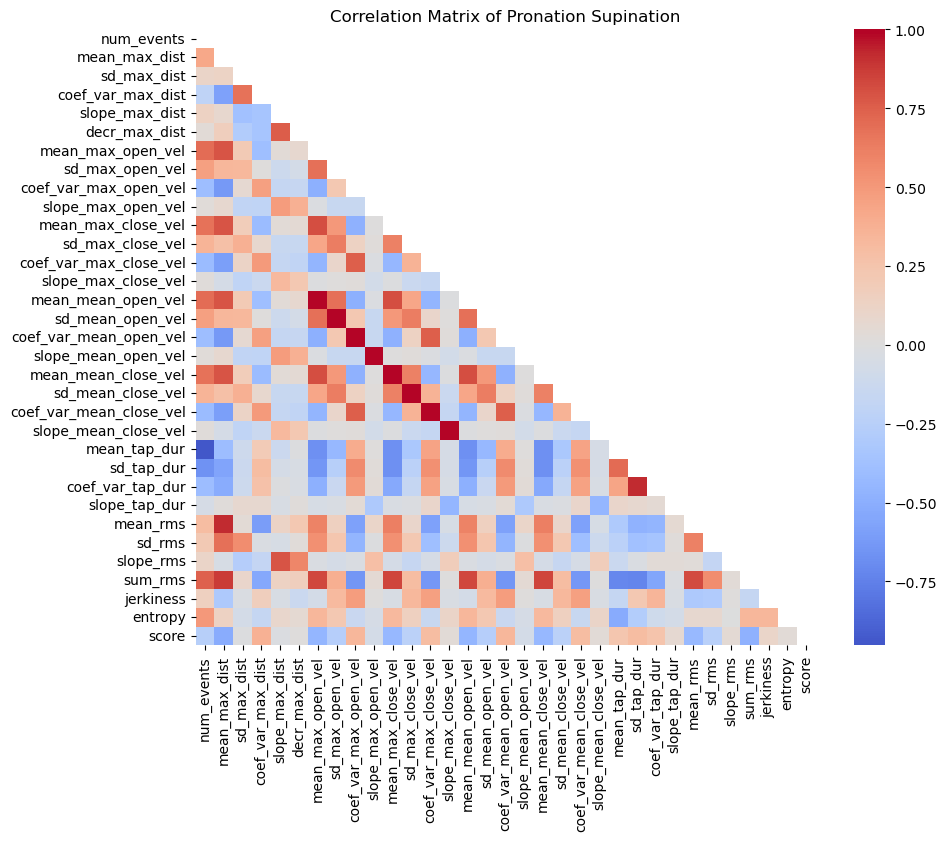

In [51]:
# load data and create correlation matrix
corr_matrix = X_df.corr(method="spearman")

# define mask to hide the upper triangle of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# create correlation matrix figure
corr_matrix_fig = plt.figure(figsize=(10,8))

# set the center of the colorscheme to 0 and define the color palette
sns.heatmap(corr_matrix, annot=False, mask=mask, center=0, cmap='coolwarm')

# set the dpi of the figure
# plt.gcf().set_dpi(300)
# plt.title(f'Correlation Matrix of {task}')
plt.title(f'Correlation Matrix of Pronation Supination')

Correlation Matrix - Pearson vs Spearman

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
# load data and create correlation matrix
corr_matrix1 = X_df.corr(method='pearson')
corr_matrix2 = X_df.corr(method='spearman')
# define mask to hide the upper triangle of the matrix
mask1 = np.triu(np.ones_like(corr_matrix1, dtype=bool))
mask2 = np.triu(np.ones_like(corr_matrix2, dtype=bool))
# create correlation matrix figure
# corr_matrix_fig = plt.figure(figsize=(6,24))

# set the center of the colorscheme to 0 and define the color palette
sns.heatmap(corr_matrix1, cbar=False, annot=False, mask=mask1, center=0, cmap='coolwarm', ax=ax1)
sns.heatmap(corr_matrix2, cbar=False, annot=False, mask=mask2, center=0, cmap='coolwarm', ax=ax2)
ax1.set_title('pearson')
ax2.set_title('spearman')
plt.tight_layout()

# set the dpi of the figure
# plt.gcf().set_dpi(300)
# plt.title(f'correlation matrix of {task}')

# corr_matrix_path = os.path.join(repo_path, 'modelling', task, 'corr_matrix')
# if not os.path.exists(corr_matrix_path):
#     os.makedirs(corr_matrix_path)
# corr_matrix_fig.savefig(os.path.join(corr_matrix_path, f'correlation_matrix_{task}'),
#                         dpi=300,facecolor='w', bbox_inches='tight')

#################################################################

Compute Intraclass Correlation Coeffiecient (ICC)

In [ ]:
conds = [X_df['file'].iloc[row].split('_')[2] for row in np.arange(0, X_df.shape[0])]
if 'cond' not in X_df.columns:   
    X_df.insert(loc=0,column='cond',value=conds)
if 'score' not in X_df.columns:
    X_df.insert(loc=X_df.shape[1],column='score',value=y)

In [ ]:
# Compute ICC
icc_dataframe = X_df[['cond', 'score', 'sub']]
icc_df = pg.intraclass_corr(data=icc_dataframe, targets='score', raters='sub', ratings='cond')

print(icc_df)

ANOVA (score)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# df is your dataframe
# features is your list of feature names
# target is your target column name

if 'score' not in X_df.columns:
        X_df.insert(loc=X_df.shape[1],column='score', value=y)

# Calculate corrected p-value threshold
alpha = 0.05
num_tests = len(X_df[:-1].columns)
corrected_alpha = alpha / num_tests

# Create an empty DataFrame to store F-values, p-values, and significance status
anova_table = pd.DataFrame(columns=['Feature', 'F-value', 'p-value', 'Significance'])

for feature in X_df.iloc[:,1:-1].columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(x=X_df['score'], y=feature, data=X_df.iloc[:,1:-1])
    
    groups = [X_df[X_df['score']==val][feature].values for val in X_df['score'].unique()]
    f_val, p_val = stats.f_oneway(*groups)
    
    # Test if p-value is significant with the corrected threshold
    significance = p_val < corrected_alpha
    signif_str = "Significant" if significance else "Not Significant"
    
    # Append the results to the anova_table
    anova_table = anova_table.append({
        'Feature': feature,
        'F-value': f_val,
        'p-value': p_val,
        'Significance': signif_str
    }, ignore_index=True)

    # Add corrected p-value to the plot
    plt.title(f"p-value = {p_val:.3f} ({signif_str})")

    plt.show()

print(anova_table)


ANOVA (condition)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


X_df['condition'] = X_df['file'].apply(lambda x: x.split('_')[2] if len(x.split('_')) > 2 else None)
# df is your dataframe
# features is your list of feature names

# Calculate corrected p-value threshold
alpha = 0.05
num_tests = len(X_df.iloc[:,1:-1].columns)
corrected_alpha = alpha / num_tests

# Create an empty DataFrame to store F-values, p-values, and significance status
anova_table = pd.DataFrame(columns=['Feature', 'F-value', 'p-value', 'Significance'])

for feature in X_df.iloc[:,1:-1].columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(x=X_df['condition'], y=feature, data=X_df.iloc[:,1:-1])
    
    groups = [X_df[X_df['condition']==val][feature].values for val in X_df['condition'].unique()]
    f_val, p_val = stats.f_oneway(*groups)
    
    # Test if p-value is significant with the corrected threshold
    significance = p_val < corrected_alpha
    signif_str = "Significant" if significance else "Not Significant"

    # Append the results to the anova_table
    anova_table = anova_table.append({
        'Feature': feature,
        'F-value': f_val,
        'p-value': p_val,
        'Significance': signif_str
    }, ignore_index=True)
    
    # Add corrected p-value to the plot
    plt.title(f"p-value = {p_val:.3f} ({signif_str})")

    plt.show()


# Print the ANOVA table
print(anova_table)

In [ ]:
columns_to_drop = 'condition'
if columns_to_drop in X_df.columns:
    X_df = X_df.drop(columns=columns_to_drop)